Code For Evaluating Models for Experiment 2

RoAs of a single retrained model (named: single), naive ensemble (named: naive), weighted ensemble (proximity scaled, named: weight), weighted ensemble (closest only, named: binary)

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import random
import tensorflow as tf
import tensorflow.keras.layers as tfl
from sklearn.preprocessing import StandardScaler, normalize
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, LambdaCallback
from tensorflow.keras.models import Sequential, load_model, Model
from scipy.signal import find_peaks

In [28]:
#Recieves data and applies z-score standardisation on all channels
def standardise(stored_data):
    scaler = StandardScaler()
    standard_stored_data = scaler.fit_transform(stored_data)
    return standard_stored_data

In [29]:
#Following code was made by adapting original code by Wen et. al (2021)
#Provided in their paper: "A convolutional neural network to identify motor units
#from high-density surface electromyography signals inreal time"
#Original code can be found here: https://github.com/ywen3/dcnn_mu_decomp/blob/main/hdEMG_DCNN.ipynb

#Used for calculating RoA during model training

def RoA_m(y_true, y_pred):
    threshold = 3*tf.math.reduce_std(y_pred)
    y_pred_binary = tf.where(y_pred>=threshold, 1., 0.)
    y_comp = y_pred_binary + y_true
    true_positives = tf.shape(tf.where(y_comp == 2))[0]
    unmatched = tf.shape(tf.where(y_comp == 1))[0]
    return true_positives/(true_positives + unmatched)


class AccuracyCallback(Callback):
    def __init__(self, metric_name = 'accuracy'):
        super().__init__()
        self.metric_name = metric_name
        self.val_metric = []
        self.metric = []
        self.val_metric_mean = 0
        self.metric_mean = 0
        self.best_metric = 0
        
    def on_epoch_end(self, epoch, logs=None):
#         print('Accuracycallback')
        # extract values from logs
        self.val_metric = []
        self.metric = []
        for log_name, log_value in logs.items():
            if log_name.find(self.metric_name) != -1:
                if log_name.find('val') != -1:
                    self.val_metric.append(log_value)
                else:
                    self.metric.append(log_value)

        self.val_metric_mean = np.mean(self.val_metric)
        self.metric_mean = np.mean(self.metric)
        logs['val_{}'.format(self.metric_name)] = np.mean(self.val_metric)   # replace it with your metrics
        logs['{}'.format(self.metric_name)] = np.mean(self.metric)   # replace it with your metrics

In [30]:
#Calculate the RoA given model predictions and true labels Y
def singleModelRoA(predictions, Y):
    y_pred = tf.squeeze(predictions)
    threshold = 3*np.std(y_pred,axis = 1)
    match = 0
    unmatch = 0
    for MU in range(len(Y)):
        pred_spikes, _ = find_peaks(y_pred[MU], height = threshold[MU], distance = 2)
        true_spikes = tf.squeeze(tf.where(np.array(Y)[MU] == 1))
        a = set(true_spikes.numpy())
        b = set(pred_spikes)
        matches = len(a.intersection(b))
        unmatched1 = a - b
        unmatched2 = b - a
        tolerance = len([x for x in unmatched1 if (x+1 in unmatched2 or x-1 in unmatched2)])
        match = match + matches + tolerance
        unmatch = unmatch + len(unmatched1) + len(unmatched2) - (2*tolerance)
    return match/(match + unmatch)

In [31]:
#Function for windowing test signal, predictions are recieved 
#from the model in batches to limit memory issues
def windowtest(EMGtrain, spiketrain, window_size, model):
    
    EMGtrain = standardise(EMGtrain)
    x_train = []
    y_train = []
    predictions = []
    count = 1
    for i in range(30,EMGtrain.shape[0]-120):
        x_train.append(EMGtrain[i-10:i+(window_size-10),:])
        y_train.append(spiketrain[i, 0:5])
        if count%8162 == 0:
            predictions.append(model(np.array(x_train)))
            x_train = []
        count = count + 1
            
    y_train = np.array(y_train)
    
    return tf.concat(predictions, axis = 1), y_train.T

In [32]:
#Get the RoAs on non-stationary signal (to make graphs to visualize generalization to unseen non-stationarity)
def getSingleRoAsOverNoise(var, noises):
    RoAs = np.zeros((5,5))
    count = 0
    for noise in noises:
        conv_model = load_model('{}_models_exp2/bestvR_big_testn{}.h5'.format(var, noise), custom_objects={"RoA_m": RoA_m})
        for fold in [1, 2, 3, 4, 5]:
            EMGtest=np.load('{}_data/{}_fold{}_x.npy'.format(var, noise, fold))
            spikes = np.load('{}_data/{}_fold{}_y.npy'.format(var, noise, fold))
            predictions, Y = windowtest(EMGtest, spikes, 60, conv_model)
            RoAs[count, fold-1] = singleModelRoA(tf.concat(predictions, axis = 1), Y)
        count = count + 1
    return RoAs

Compute and save RoAs for single retrained model

In [ ]:
var = 'noise'
noises = ['20dB','15dB','10dB','5dB','0dB']
RoAs_single_noise = getSingleRoAsOverNoise(var, noises)
np.save('Results/Exp2/RoAs_single_{}'.format(var),RoAs_single_noise)

In [ ]:
var = 'MUs'
noises = ['10MUs','20MUs','30MUs','40MUs','50MUs']
RoAs_single_MUs = getSingleRoAsOverNoise(var, noises)
np.save('Results/Exp2/RoAs_single_{}'.format(var),RoAs_single_MUs)

In [ ]:
var = 'lowpass'
noises = ['500Hz', '300Hz', '200Hz', '150Hz', '125Hz']
RoAs_single_lowpass = getSingleRoAsOverNoise(var, noises)
np.save('Results/Exp2/RoAs_single_{}'.format(var),RoAs_single_lowpass)

In [ ]:
var = 'shift'
noises = ['0mm','2mm','4mm','6mm','8mm']
RoAs_single_shift = getSingleRoAsOverNoise(var, noises)
np.save('Results/Exp2/RoAs_single_{}'.format(var),RoAs_single_shift)

In [ ]:
#Here the RoAs over the folds is calculated for the single retrained model (for bar graph)
RoAs_single = np.zeros((4,5))
variables = ['noise','MUs','lowpass','shift']
full_noises = [['20dB','15dB','10dB','5dB','0dB'],
                ['10MUs','20MUs','30MUs','40MUs','50MUs'],
                ['500Hz', '300Hz', '200Hz', '150Hz', '125Hz'],
                ['0mm','2mm','4mm','6mm','8mm']]
count = 0
for var in variables:
    count2 = 0
    for noise in full_noises[count]:
        predictions = []
        conv_model = load_model('{}_models_exp2/bestvR_big_testn{}.h5'.format(var, noise), custom_objects={"RoA_m": RoA_m})
        inter = False
        for fold in [1, 2, 3, 4, 5]:
            EMGtest=np.load('{}_data/{}_fold{}_x.npy'.format(var, noise, fold))
            spikes = np.load('{}_data/{}_fold{}_y.npy'.format(var, noise, fold))
            predictions_mini, Y_mini = windowtest(EMGtest, spikes, 60, conv_model)
            predictions.append(predictions_mini)
            if inter == False:
                Y = Y_mini
            else:
                Y = np.concatenate((Y, Y_mini), axis = 1)
            inter = True
        RoAs_single[count, count2] = singleModelRoA(tf.concat(predictions, axis = 1), Y)
        count2 = count2 + 1
        print('Noise ' + noise + ' done')
    count = count + 1
np.save('Results/Exp2/RoAs_single',RoAs_single)

Here, ensemble model is made by combining multiple models trained at different stationary signals

In [36]:
#Generates the ensemble model by combining multiple models
def ensemble_model_gen(input_shape, names):
    input_signal = tf.keras.Input(shape = input_shape)
    out = []
    
    for i in names:
        output = load_model(i, custom_objects={"RoA_m": RoA_m})(input_signal)
        out.append(output)
    
    model = tf.keras.Model(inputs = input_signal, outputs = out)
    return model

In [33]:
#Function for windowing test signal, predictions are recieved 
#from the model in batches to limit memory issues
#Made of ensemble model
def windowtestEnsemble(EMGtrain, spiketrain, window_size, model):
    EMGtrain = standardise(EMGtrain)
    x_train = []
    y_train = []
    predictions = []
    count = 1
    for i in range(30,EMGtrain.shape[0]-120):
        x_train.append(EMGtrain[i-10:i+(window_size-10),:])
        y_train.append(spiketrain[i, 0:5])
        if count%8162 == 0:
            predictions.append(model(np.array(x_train)))
            x_train = []
        count = count + 1
            
    y_train = np.array(y_train)
    return tf.concat(predictions, axis = 2), y_train.T

In [34]:
#Provides the predictoins of the ensmble with naive weighting
def naiveEnsemblePredict(output):
    y_pred = tf.math.add_n(output)
    y_pred = tf.squeeze(y_pred,2)
    return y_pred

In [35]:
#Provides the predictions of the ensemble with model weighting
def weightedEnsemblePredict(output, weights):
    output = tf.squeeze(output)
    output = tf.transpose(output,[2,1,0])
    output = tf.multiply(output,weights)
    output = tf.transpose(output,[2,1,0])
    y_pred = tf.math.add_n(output)
    return y_pred

In [37]:
#Get the RoAs on non-stationary signal with naive weighting (to make graphs to visualize robustness)
def getNaiveRoAsOverNoise(var, noises):
    RoAs = np.zeros((5,5))
    count = 0
    for noise in noises:
        training_noises = [s for s in noises if s != noise]
        names = []
        for n in training_noises:
            names.append('{}_models_exp2/bestvR_{}trained.h5'.format(var, n))
        ensemble_model = ensemble_model_gen((60, 192), names)
        for fold in [1, 2, 3, 4, 5]:
            EMGtest=np.load('{}_data/{}_fold{}_x.npy'.format(var, noise, fold))
            spikes = np.load('{}_data/{}_fold{}_y.npy'.format(var, noise, fold))
            outputs, Y = windowtestEnsemble(EMGtest, spikes, 60, ensemble_model)
            predictions = naiveEnsemblePredict(outputs)
            RoAs[count, fold-1] = singleModelRoA(tf.concat(predictions, axis = 1), Y)
        count = count + 1
    return RoAs

Compute and save RoAs for naive ensemble model

In [ ]:
var = 'noise'
noises = ['20dB','15dB','10dB','5dB','0dB']
RoAs_naive_noise = getNaiveRoAsOverNoise(var, noises)
np.save('Results/Exp2/RoAs_naive_{}'.format(var),RoAs_naive_noise)

In [ ]:
var = 'MUs'
noises = ['10MUs','20MUs','30MUs','40MUs','50MUs']
RoAs_naive_MUs = getNaiveRoAsOverNoise(var, noises)
np.save('Results/Exp2/RoAs_naive_{}'.format(var),RoAs_naive_MUs)

In [ ]:
var = 'lowpass'
noises = ['500Hz', '300Hz', '200Hz', '150Hz', '125Hz']
RoAs_naive_lowpass = getNaiveRoAsOverNoise(var, noises)
np.save('Results/Exp2/RoAs_naive_{}'.format(var),RoAs_naive_lowpass)

In [ ]:
var = 'shift'
noises = ['0mm','2mm','4mm','6mm','8mm']
RoAs_naive_shift = getNaiveRoAsOverNoise(var, noises)
np.save('Results/Exp2/RoAs_naive_{}'.format(var),RoAs_naive_shift)

In [ ]:
#Here the RoAs over the folds is calculated for the naive ensemble model (for bar graph)
RoAs_naive = np.zeros((4,5))
variables = ['noise','MUs','lowpass','shift']
full_noises = [['20dB','15dB','10dB','5dB','0dB'],
                ['10MUs','20MUs','30MUs','40MUs','50MUs'],
                ['500Hz', '300Hz', '200Hz', '150Hz', '125Hz'],
                ['0mm','2mm','4mm','6mm','8mm']]
count = 0
for var in variables:
    count2 = 0
    for test_noise in full_noises[count]:
        predictions = []
        training_noises = [s for s in full_noises[count] if s != test_noise]
        names = []
        for n in training_noises:
            names.append('{}_models_exp2/bestvR_{}trained.h5'.format(var, n))
        ensemble_model = ensemble_model_gen((60, 192), names)
        inter = False
        for fold in [1, 2, 3, 4, 5]:
            EMGtest=np.load('{}_data/{}_fold{}_x.npy'.format(var, test_noise, fold))
            spikes = np.load('{}_data/{}_fold{}_y.npy'.format(var, test_noise, fold))
            outputs, Y_mini = windowtestEnsemble(EMGtest, spikes, 60, ensemble_model)
            predictions_mini = naiveEnsemblePredict(outputs)
            predictions.append(predictions_mini)
            if inter == False:
                Y = Y_mini
            else:
                Y = np.concatenate((Y, Y_mini), axis = 1)
            inter = True
        RoAs_naive[count, count2] = singleModelRoA(tf.concat(predictions, axis = 1), Y)
        count2 = count2 + 1
        print('Noise ' + test_noise + ' done')
    count = count + 1
np.save('Results/Exp2/RoAs_naive',RoAs_naive)

Here, the mean, variance and signal power of every generated simulated signal segment is stored in an array and saved

These statistics will be used to weight the models based on the signal statistics of model's training set and comparing it to the statistics of the test set

In [ ]:
variables = ['noise','MUs','lowpass','shift']
full_noises = [['20dB','15dB','10dB','5dB','0dB'],
                ['10MUs','20MUs','30MUs','40MUs','50MUs'],
                ['500Hz', '300Hz', '200Hz', '150Hz', '125Hz'],
                ['0mm','2mm','4mm','6mm','8mm']]
for n in noises:
    comb_train_stats = []
    for fold in folds:
        stats = np.zeros((3,192))
        EMGtrain = np.load('{}_data/{}_fold{}_x.npy'.format(var, n, fold))
        sig_Power = np.zeros(192)
        for i in range(192):
            sigWelch = welch(EMGtrain.T[i,:],2048)
            sig_Power[i] = np.sum(sigWelch[1]) * (sigWelch[0][1] - sigWelch[0][0])
        stats[0] = np.var(EMGtrain, axis = 0)
        stats[1] = np.mean(EMGtrain, axis = 0)
        stats[2] = sig_Power
        np.save('{}_data/{}_fold{}_x_stats'.format(var, n, fold), stats)

In [38]:
#Gets model weights based on model proximity to test set
#Adjusted for Experiment 2
def getWeightsFastScaledExp2(var, test_noise, test_fold, training_noises):
    test_stats = np.load('{}_data/{}_fold{}_x_stats.npy'.format(var, test_noise, test_fold))
    dist_metric = []
    
    training_folds = [1,2,3,4,5]
    for n in training_noises:
        comb_train_stats = []
        for fold in training_folds:
            train_stats = np.load('{}_data/{}_fold{}_x_stats.npy'.format(var, n, fold))
            comb_train_stats.append(train_stats)
        dist_metric.append(np.linalg.norm(test_stats - np.mean(comb_train_stats, axis = 0)))
    dist_array = np.array(dist_metric)
    return (1 - normalize(dist_array.reshape(1,-1)))
    #return np.where(dist_array == np.min(dist_array), 1, 0)

In [39]:
#Get the RoAs on non-stationary signal with proximity scaled weighting (to make graphs to visualize robustness)
def getScaledWeightedRoAsOverNoise(var, noises):
    RoAs = np.zeros((5,5))
    count = 0
    for noise in noises:
        training_noises = [s for s in noises if s != noise]
        names = []
        for n in training_noises:
            names.append('{}_models_exp2/bestvR_{}trained.h5'.format(var, n))
        ensemble_model = ensemble_model_gen((60, 192), names)
        for fold in [1, 2, 3, 4, 5]:
            EMGtest=np.load('{}_data/{}_fold{}_x.npy'.format(var, noise, fold))
            spikes = np.load('{}_data/{}_fold{}_y.npy'.format(var, noise, fold))
            outputs, Y = windowtestEnsemble(EMGtest, spikes, 60, ensemble_model)
            weights = getWeightsFastScaledExp2(var, noise, fold, training_noises)
            predictions = weightedEnsemblePredict(outputs, weights)
            RoAs[count, fold-1] = singleModelRoA(tf.concat(predictions, axis = 1), Y)
        count = count + 1
    return RoAs

Compute and save RoAs for proximity weighted ensemble model

In [ ]:
var = 'noise'
noises = ['20dB','15dB','10dB','5dB','0dB']
RoAs_weight_noise = getScaledWeightedRoAsOverNoise(var, noises)
np.save('Results/Exp2/RoAs_weight_{}'.format(var),RoAs_weight_noise)

In [ ]:
var = 'MUs'
noises = ['10MUs','20MUs','30MUs','40MUs','50MUs']
RoAs_weight_MUs = getScaledWeightedRoAsOverNoise(var, noises)
np.save('Results/Exp2/RoAs_weight_{}'.format(var),RoAs_weight_MUs)

In [ ]:
var = 'lowpass'
noises = ['500Hz', '300Hz', '200Hz', '150Hz', '125Hz']
RoAs_weight_lowpass = getScaledWeightedRoAsOverNoise(var, noises)
np.save('Results/Exp2/RoAs_weight_{}'.format(var),RoAs_weight_lowpass)

In [ ]:
var = 'shift'
noises = ['0mm','2mm','4mm','6mm','8mm']
RoAs_weight_shift = getScaledWeightedRoAsOverNoise(var, noises)
np.save('Results/Exp2/RoAs_weight_{}'.format(var),RoAs_weight_shift)

In [ ]:
#Here the RoAs over the folds is calculated for the proximity weighted ensemble model (for bar graph)
RoAs_weight = np.zeros((4,5))
variables = ['noise','MUs','lowpass','shift']
full_noises = [['20dB','15dB','10dB','5dB','0dB'],
                ['10MUs','20MUs','30MUs','40MUs','50MUs'],
                ['500Hz', '300Hz', '200Hz', '150Hz', '125Hz'],
                ['0mm','2mm','4mm','6mm','8mm']]
count = 0
for var in variables:
    count2 = 0
    for test_noise in full_noises[count]:
        predictions = []
        training_noises = [s for s in full_noises[count] if s != test_noise]
        names = []
        for n in training_noises:
            names.append('{}_models_exp2/bestvR_{}trained.h5'.format(var, n))
        ensemble_model = ensemble_model_gen((60, 192), names)
        inter = False
        for fold in [1, 2, 3, 4, 5]:
            EMGtest=np.load('{}_data/{}_fold{}_x.npy'.format(var, test_noise, fold))
            spikes = np.load('{}_data/{}_fold{}_y.npy'.format(var, test_noise, fold))
            outputs, Y_mini = windowtestEnsemble(EMGtest, spikes, 60, ensemble_model)
            weights = getWeightsFastScaledExp2(var, test_noise, fold, training_noises)
            predictions_mini = weightedEnsemblePredict(outputs, weights)
            predictions.append(predictions_mini)
            if inter == False:
                Y = Y_mini
            else:
                Y = np.concatenate((Y, Y_mini), axis = 1)
            inter = True
        RoAs_weight[count, count2] = singleModelRoA(tf.concat(predictions, axis = 1), Y)
        count2 = count2 + 1
        print('Noise ' + test_noise + ' done')
    count = count + 1
np.save('Results/Exp2/RoAs_weight',RoAs_weight)

In [40]:
#Weights the closet model only
#Adjusted for Experiment 2
def getWeightsFastBinaryExp2(var, test_noise, test_fold, training_noises):
    test_stats = np.load('{}_data/{}_fold{}_x_stats.npy'.format(var, test_noise, test_fold))
    dist_metric = []
    
    training_folds = [1,2,3,4,5]
    for n in training_noises:
        comb_train_stats = []
        for fold in training_folds:
            train_stats = np.load('{}_data/{}_fold{}_x_stats.npy'.format(var, n, fold))
            comb_train_stats.append(train_stats)
        dist_metric.append(np.linalg.norm(test_stats - np.mean(comb_train_stats, axis = 0)))
    dist_array = np.array(dist_metric)
    #return (1 - normalize(dist_array.reshape(1,-1)))
    return np.where(dist_array == np.min(dist_array), 1, 0)

In [41]:
#Get the RoAs on non-stationary signal with closest only weighting (to make graphs to visualize robustness)
def getBinaryWeightedRoAsOverNoise(var, noises):
    RoAs = np.zeros((5,5))
    count = 0
    for noise in noises:
        training_noises = [s for s in noises if s != noise]
        names = []
        for n in training_noises:
            names.append('{}_models_exp2/bestvR_{}trained.h5'.format(var, n))
        ensemble_model = ensemble_model_gen((60, 192), names)
        for fold in [1, 2, 3, 4, 5]:
            EMGtest=np.load('{}_data/{}_fold{}_x.npy'.format(var, noise, fold))
            spikes = np.load('{}_data/{}_fold{}_y.npy'.format(var, noise, fold))
            outputs, Y = windowtestEnsemble(EMGtest, spikes, 60, ensemble_model)
            weights = getWeightsFastBinaryExp2(var, noise, fold, training_noises)
            predictions = weightedEnsemblePredict(outputs, weights)
            RoAs[count, fold-1] = singleModelRoA(tf.concat(predictions, axis = 1), Y)
        count = count + 1
    return RoAs

Compute and save RoAs for closest only weighted ensemble model

In [ ]:
var = 'noise'
noises = ['20dB','15dB','10dB','5dB','0dB']
RoAs_binary_noise = getBinaryWeightedRoAsOverNoise(var, noises)
np.save('Results/Exp2/RoAs_binary_{}'.format(var),RoAs_binary_noise)

In [ ]:
var = 'MUs'
noises = ['10MUs','20MUs','30MUs','40MUs','50MUs']
RoAs_binary_MUs = getBinaryWeightedRoAsOverNoise(var, noises)
np.save('Results/Exp2/RoAs_binary_{}'.format(var),RoAs_binary_MUs)

In [ ]:
var = 'lowpass'
noises = ['500Hz', '300Hz', '200Hz', '150Hz', '125Hz']
RoAs_binary_lowpass = getBinaryWeightedRoAsOverNoise(var, noises)
np.save('Results/Exp2/RoAs_binary_{}'.format(var),RoAs_binary_lowpass)

In [ ]:
var = 'shift'
noises = ['0mm','2mm','4mm','6mm','8mm']
RoAs_binary_shift = getBinaryWeightedRoAsOverNoise(var, noises)
np.save('Results/Exp2/RoAs_binary_{}'.format(var),RoAs_binary_shift)

In [ ]:
#Here the RoAs over the folds is calculated for the closest only weighted ensemble model (for bar graph)
RoAs_binary = np.zeros((4,5))
variables = ['noise','MUs','lowpass','shift']
full_noises = [['20dB','15dB','10dB','5dB','0dB'],
                ['10MUs','20MUs','30MUs','40MUs','50MUs'],
                ['500Hz', '300Hz', '200Hz', '150Hz', '125Hz'],
                ['0mm','2mm','4mm','6mm','8mm']]
count = 0
for var in variables:
    count2 = 0
    for test_noise in full_noises[count]:
        predictions = []
        training_noises = [s for s in full_noises[count] if s != test_noise]
        names = []
        for n in training_noises:
            names.append('{}_models_exp2/bestvR_{}trained.h5'.format(var, n))
        ensemble_model = ensemble_model_gen((60, 192), names)
        inter = False
        for fold in [1, 2, 3, 4, 5]:
            EMGtest=np.load('{}_data/{}_fold{}_x.npy'.format(var, test_noise, fold))
            spikes = np.load('{}_data/{}_fold{}_y.npy'.format(var, test_noise, fold))
            outputs, Y_mini = windowtestEnsemble(EMGtest, spikes, 60, ensemble_model)
            weights = getWeightsFastBinaryExp2(var, test_noise, fold, training_noises)
            predictions_mini = weightedEnsemblePredict(outputs, weights)
            predictions.append(predictions_mini)
            if inter == False:
                Y = Y_mini
            else:
                Y = np.concatenate((Y, Y_mini), axis = 1)
            inter = True
        RoAs_binary[count, count2] = singleModelRoA(tf.concat(predictions, axis = 1), Y)
        count2 = count2 + 1
        print('Noise ' + test_noise + ' done')
    count = count + 1
np.save('Results/Exp2/RoAs_binary',RoAs_binary)

Get graphs of RoA results calculated above

In [2]:
#Get the median and IQR of the RoAs over test folds
def medError(RoAs):
    med = np.median(RoAs, axis = 1)
    error = abs(np.percentile(RoAs, [25, 75], axis = 1) - med)
    return med*100, error*100

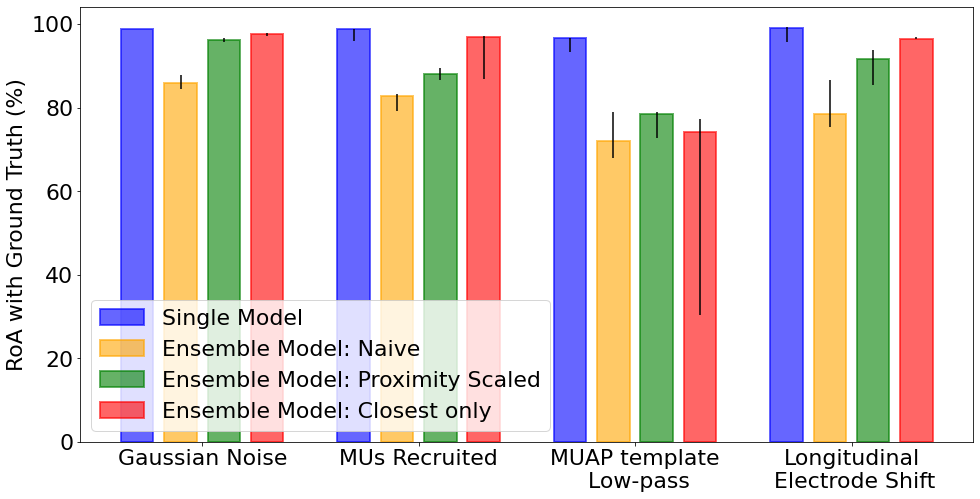

In [3]:
plt.figure(figsize=(16, 8))
plt.rcParams.update({'font.size': 22})
vars = ['Gaussian Noise', 'MUs Recruited', 'MUAP template\n Low-pass', 'Longitudinal\n Electrode Shift']
X = np.arange(len(vars))

med_single, error_single = medError(np.load('Results/Exp2/RoAs_single.npy'))

med_naive, error_naive = medError(np.load('Results/Exp2/RoAs_naive.npy'))

med_weight, error_weight = medError(np.load('Results/Exp2/RoAs_weight.npy'))

med_binary, error_binary = medError(np.load('Results/Exp2/RoAs_binary.npy'))

plt.bar(X-.3,med_single,.15, yerr = error_single,  edgecolor = 'blue', facecolor = 'blue', linewidth = 2, label = 'Single Model', alpha = 0.6)
plt.bar(X-.1,med_naive,.15, yerr = error_naive, edgecolor = 'orange', facecolor = 'orange', linewidth = 2, label = 'Ensemble Model: Naive', alpha = 0.6)
plt.bar(X+.1,med_weight,.15, yerr = error_weight, edgecolor = 'green', facecolor = 'green', linewidth = 2, label = 'Ensemble Model: Proximity Scaled', alpha = 0.6)
plt.bar(X+.3,med_binary,.15, yerr = error_binary, edgecolor = 'red', facecolor = 'red', linewidth = 2, label = 'Ensemble Model: Closest only', alpha = 0.6)

plt.legend(loc = 3)
plt.xticks(X, vars)
plt.ylabel('RoA with Ground Truth (%)')
plt.show()

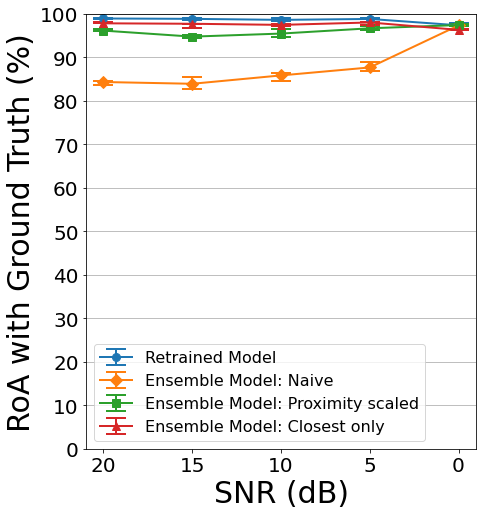

In [45]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(7, 8))
noises_int = [20,15,10,5,0]
var = 'noise'
noises = ['20 dB','15 dB','10 dB','5 dB','0 dB']
markers = ['o-','D-','s-','^-','X-']
style = ['single', 'naive', 'weight', 'binary']
count = 0
for n in style:
    RoAs = np.load('Results/Exp2/RoAs_{}_{}.npy'.format(n,var))
    med, error = medError(RoAs)
    plt.errorbar(noises_int,med.T,yerr=error,fmt=markers[count], markersize = 8, capsize=10, linewidth = 2, capthick = 2)
    count = count + 1
    
plt.axis([max(noises_int)+1,min(noises_int)-1,0,100])
plt.xlabel('SNR (dB)', fontsize = 30)
plt.ylabel('RoA with Ground Truth (%)', fontsize = 30)
plt.legend(['Retrained Model','Ensemble Model: Naive','Ensemble Model: Proximity scaled', 'Ensemble Model: Closest only'],fontsize=16, title_fontsize=16)
plt.xticks(noises_int)
plt.yticks([0,10,20,30,40,50,60,70,80,90,100])
plt.grid(axis="y")
plt.show()

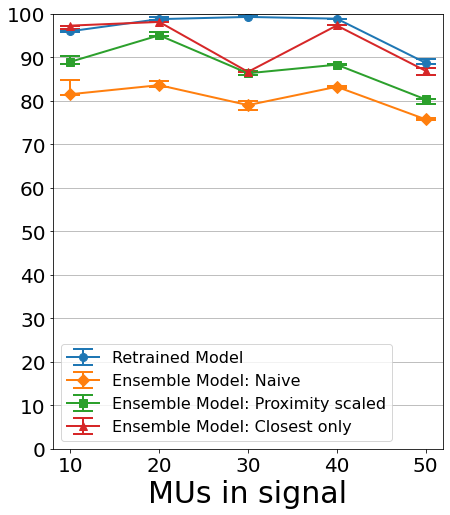

In [46]:
plt.figure(figsize=(7, 8))
noises = ['10MUs','20MUs', '30MUs', '40MUs', '50MUs']
noises_int = [10,20,30,40,50]
var = 'MUs'
markers = ['o-','D-','s-','^-','X-']
style = ['single', 'naive', 'weight', 'binary']
count = 0
for n in style:
    RoAs = np.load('Results/Exp2/RoAs_{}_{}.npy'.format(n,var))
    med, error = medError(RoAs)
    plt.errorbar(noises_int,med.T,yerr=error,fmt=markers[count], markersize = 8, capsize=10, linewidth = 2, capthick = 2)
    count = count + 1
    
plt.axis([min(noises_int)-2,max(noises_int)+2,0,100])
plt.xlabel('MUs in signal', fontsize = 30)
plt.legend(noises, title="Model trained at:", fontsize=16, title_fontsize=16)
plt.xticks(noises_int, noises_int)
plt.yticks([0,10,20,30,40,50,60,70,80,90,100])
plt.grid(axis="y")
plt.legend(['Retrained Model','Ensemble Model: Naive','Ensemble Model: Proximity scaled', 'Ensemble Model: Closest only'],fontsize=16, title_fontsize=16)
plt.show()

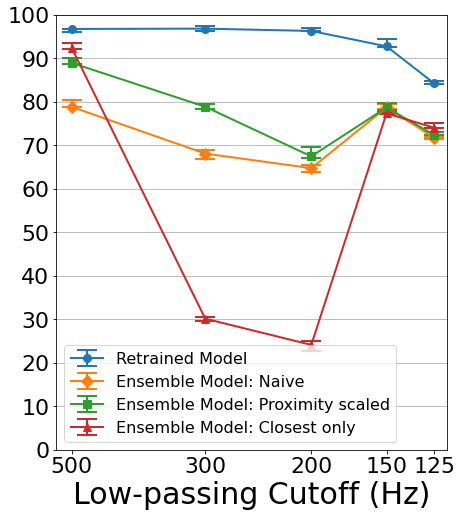

In [4]:
plt.figure(figsize=(7, 8))
noises = ['500 Hz', '300 Hz', '200 Hz', '150 Hz', '125 Hz']
noises_int = [500,300,200,150,125]
var = 'lowpass'
markers = ['o-','D-','s-','^-','X-']
style = ['single', 'naive', 'weight', 'binary']
count = 0
for n in style:
    RoAs = np.load('Results/Exp2/RoAs_{}_{}.npy'.format(n,var))
    med, error = medError(RoAs)
    plt.errorbar(noises_int,med.T,yerr=error,fmt=markers[count], markersize = 8, capsize=10, linewidth = 2, capthick = 2)
    count = count + 1
    
plt.axis([max(noises_int)+30,min(noises_int)-6,0,100])
plt.xlabel('Low-passing Cutoff (Hz)', fontsize = 30)
plt.legend(noises, title="Model trained at:", fontsize=16, title_fontsize=16)
plt.xscale('log')
plt.xticks(noises_int, noises_int)
plt.minorticks_off()
plt.yticks([0,10,20,30,40,50,60,70,80,90,100])
plt.grid(axis="y")
plt.legend(['Retrained Model','Ensemble Model: Naive','Ensemble Model: Proximity scaled', 'Ensemble Model: Closest only'],fontsize=16, title_fontsize=16)
plt.show()

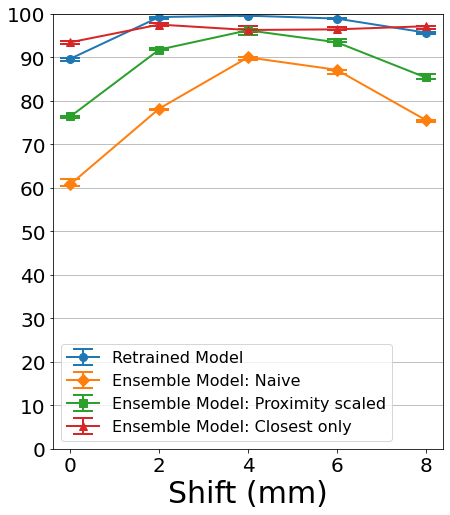

In [48]:
plt.figure(figsize=(7, 8))
noises = ['0mm','2mm', '4mm', '6mm', '8mm']
noises_int = [0,2,4,6,8]
var = 'shift'
markers = ['o-','D-','s-','^-','X-']
style = ['single', 'naive', 'weight', 'binary']
count = 0
for n in style:
    RoAs = np.load('Results/Exp2/RoAs_{}_{}.npy'.format(n,var))
    med, error = medError(RoAs)
    plt.errorbar(noises_int,med.T,yerr=error,fmt=markers[count], markersize = 8, capsize=10, linewidth = 2, capthick = 2)
    count = count + 1

plt.axis([min(noises_int)-.4,max(noises_int)+.4,0,100])
plt.xlabel('Shift (mm)', fontsize = 30)
plt.legend(noises, title="Model trained at:",  fontsize=16, title_fontsize=16)
plt.xticks(noises_int, noises_int)
plt.yticks([0,10,20,30,40,50,60,70,80,90,100])
plt.grid(axis="y")
plt.legend(['Retrained Model','Ensemble Model: Naive','Ensemble Model: Proximity scaled', 'Ensemble Model: Closest only'],fontsize=16, title_fontsize=16)
plt.show()